In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize

We can rewrite Schroedingers equation to bring it to the Numerov form:
$$
\begin{align}
\frac{d^2 u}{dx^2} &= - \frac{2 m}{\hbar^2} (E - V(x)) u(x), \\
q(x) &= \frac{2 m}{\hbar^2} (E - V(x)), \\
s(x) &= 0
\end{align}
$$

In [13]:

class Schroedinger : 

    def __init__(self) :
        self.hbar = 1.0                  # Planck's constant / 2pi
        self.m = 1.0                     # particle mass
        self.omega = 1.0                 # oscillator frequency
        self.E = 0.0                     # current energy in search
        self.N = 500                     # number of lattice points = N+1
        self.x_left = -10.0               # left boundary
        self.x_right = 10.0               # right boundary
        self.h = (self.x_right - self.x_left) / self.N  # grid spacing
        self.xvals = np.linspace(self.x_left,self.x_right,self.N+1) # x value for phi
        self.phi_left = np.zeros(self.N+1)  # wave function integrating from left
        self.phi_right = np.zeros(self.N+1) # wave function integrating from right
        self.phi = np.zeros(self.N+1)       # whole wave function
        self.i_match = 0                 # Index of turning point
        self.x_match = 0.                # Turning point x value 
        self.sign = 1                    # current sign used to make F(E) continuous
        self.nodes = 0                   # current number of nodes in wavefunction
        self.pert1 = 0.0                 # pertubation 3th order
        self.pert2 = 0.0                 # pertubation 4th order


    def V(self, x):                   # harmonic oscillator potential
        return 0.5 * self.m * self.omega**2 * (x**2 + self.pert1 * x**3 + self.pert2 * x**4)


    def q(self, x):                   # Sturm-Liouville q function
        return 2 * self.m / self.hbar**2 * (self.E - self.V(x))


    def F(self, energy):              # eigenvalue at F(E) = 0

        # set energy needed by the q(x) function
        self.E = energy

        # find the right turning point
        self.i_match = self.N
        
        
        x = self.x_right             # start at right boundary
        while self.V(x) > self.E:         # in forbidden region
            self.i_match -= 1
            x -= self.h
            if self.i_match < 0:
                raise Exception("can't find right turning point")
        self.x_match = self.xvals[ self.i_match ]
        
        # integrate self.phi_left using Numerov algorithm
        self.phi_left[0] = 0.0
        self.phi_left[1] = 1.0e-10
        c = self.h**2 / 12.0         # constant in Numerov formula
        for i in range(1, self.i_match+1):
            x = self.x_left + i * self.h
            self.phi_left[i+1]  = 2 * (1 - 5 * c * self.q(x)) * self.phi_left[i]
            self.phi_left[i+1] -= (1 + c * self.q(x - self.h)) * self.phi_left[i-1]
            self.phi_left[i+1] /= 1 + c * self.q(x + self.h)

        # integrate self.phi_right
        self.phi[self.N] = self.phi_right[self.N] = 0.0
        self.phi[self.N-1] = self.phi_right[self.N-1] = 1.0e-10
        for i in range(self.N - 1, self.i_match - 1, -1):
            x = self.x_right - i * self.h
            self.phi_right[i-1]  = 2 * (1 - 5 * c * self.q(x)) * self.phi_right[i]
            self.phi_right[i-1] -= (1 + c * self.q(x + self.h)) * self.phi_right[i+1]
            self.phi_right[i-1] /= 1 + c * self.q(x - self.h)
            self.phi[i-1] = self.phi_right[i-1]

        # rescale self.phi_left
        scale = self.phi_right[self.i_match] / self.phi_left[self.i_match]
        for i in range(self.i_match + 2):
            self.phi_left[i] *= scale
            self.phi[i] = self.phi_left[i]

        # make F(E) continuous
        # count number of nodes in self.phi_left
        n = 0
        for i in range(1, self.i_match+1):
            if self.phi_left[i-1] * self.phi_left[i] < 0.0:
                n += 1

        # flip its sign when a new node develops

        if n != self.nodes:
            self.nodes = n
            self.sign = -self.sign

        return ( self.sign *
         ( self.phi_right[self.i_match-1] - self.phi_right[self.i_match+1] - 
           self.phi_left [self.i_match-1] + self.phi_left[self.i_match+1] ) /
        (2 * self.h * self.phi_right[self.i_match]) )

    def normalize(self):
        norm = 0.0
        norm = np.sqrt( np.sum( self.phi**2 ) / self.N )
        self.phi = self.phi / norm


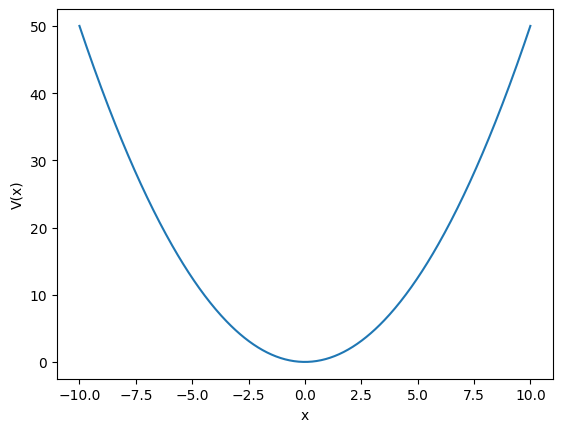

In [14]:
schroedinger = Schroedinger()
schroedinger.pert1 = .0
schroedinger.pert2 = .0

x = schroedinger.x_left + schroedinger.h * np.linspace(0, schroedinger.N, schroedinger.N+1)
vx = schroedinger.V(x)
plt.plot(x,vx)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.show()

-: 1.00 0.50
+: 1.00 0.50
-: 1.73 1.50
+: 1.73 1.50
-: 2.24 2.50
+: 2.24 2.50
-: 2.65 3.50
+: 2.65 3.50
-: 3.00 4.50
+: 3.00 4.50
-: 3.32 5.50
+: 3.32 5.50
-: 3.61 6.50
+: 3.61 6.50
-: 3.87 7.50
+: 3.87 7.50
-: 4.12 8.50
+: 4.12 8.50
-: 4.36 9.50
+: 4.36 9.50
-: 4.58 10.50
+: 4.58 10.50


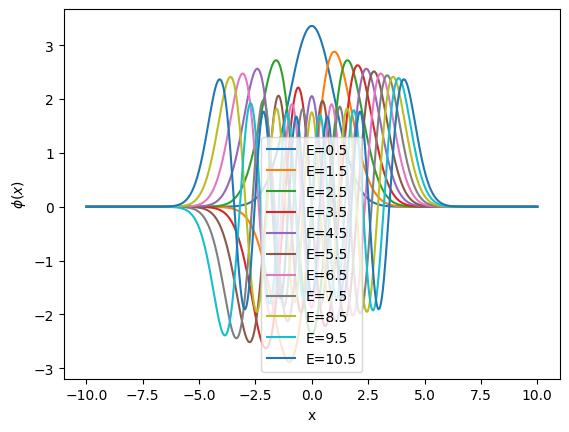

In [15]:

# find the energy levels
E_max = 10.0
schroedinger.E = 0.1        # guess an E below the ground state
level = 0                   # level number
E_old = 0.0                 # previous energy eigenvalue
schroedinger.pert1 = 0.0    # 3rd order pertubation
schroedinger.pert2 = 0.0    # 4th order pertubation 

while True:                 # loop over levels

    # estimate next E and dE
    dE = 0.5 * (schroedinger.E - E_old)
    E_old = schroedinger.E
    schroedinger.E += dE

    res = scipy.optimize.root_scalar( schroedinger.F, 
                                     x0=schroedinger.E, 
                                     x1=schroedinger.E+dE )    
    schroedinger.E = res.root
    
    level += 1
    
    res = scipy.optimize.root_scalar( schroedinger.q, 
                                     x0=schroedinger.x_left, 
                                     x1=schroedinger.x_match )
    x = res.root
    swrite = '-: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)
    
    res = scipy.optimize.root_scalar( schroedinger.q, 
                                     x0=schroedinger.x_match, 
                                     x1=schroedinger.x_right )
    x = res.root
    swrite = '+: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)

    
    schroedinger.normalize()
    xvals = schroedinger.x_left + schroedinger.h * np.arange(schroedinger.N+1)
    
    plt.plot(xvals, schroedinger.phi, label="E=%2.1f" % (schroedinger.E) )

    if schroedinger.E >= E_max:          # we are done
        break
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi(x)$")
plt.show()

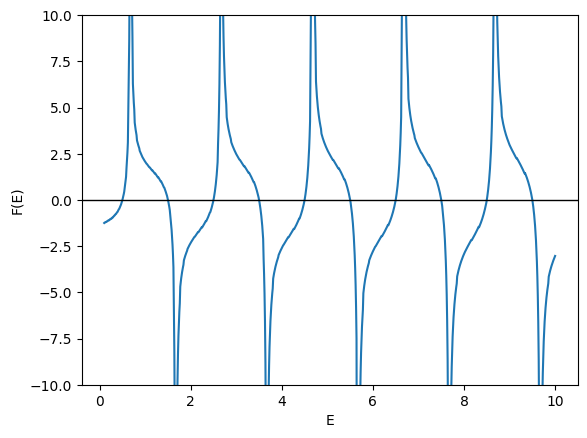

In [16]:
%matplotlib inline
# print the search function
schroedinger.E = 0.1
dE = 0.01
E_data = []
F_data = []
while schroedinger.E < E_max:
    E_data.append( schroedinger.E )
    F_data.append(  schroedinger.F(schroedinger.E) )
    schroedinger.E += dE

plt.plot(E_data,F_data)
plt.ylim(-10,10)
plt.xlabel("E")
plt.ylabel("F(E)")
plt.axhline(linewidth=1, color='k')
plt.show()